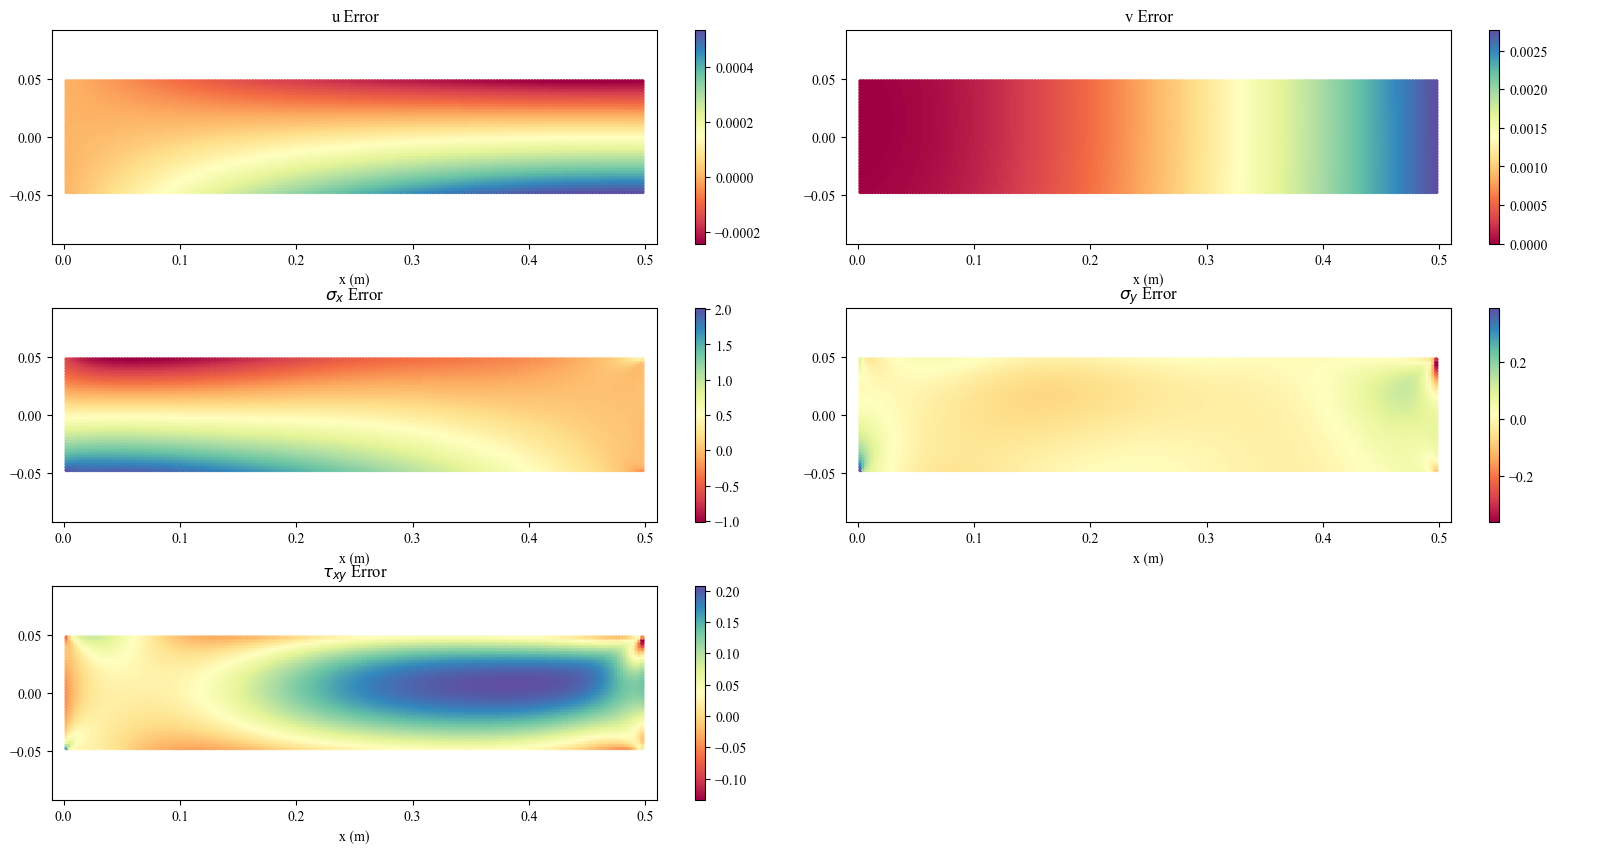

In [6]:
###绘制绝对误差
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.spatial import cKDTree

# 设置字体为新罗马字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# 定义坐标边界
xmin, xmax = -0.01, 0.51
ymin, ymax = -0.075, 0.075

# 保存图像的路径
save_path = '../Error analysis/'
displacement_file = '../FEM/displacement_data.csv'
stress_file = '../FEM/stress_data.csv'
mat_file = '../CPU/out.mat'

#def plot_error(displacement_file, stress_file, mat_file, save_path):
    # 读取CSV文件
displacement_data = pd.read_csv(displacement_file)
stress_data = pd.read_csv(stress_file)

# 读取MAT文件
mat_data = scipy.io.loadmat(mat_file)

# 获取基准数据
ref_coords = displacement_data[['X', 'Y']].values
u_ref = displacement_data['Disp_x'].values
v_ref = displacement_data['Disp_y'].values
sigma_x_ref = stress_data['Sigma_x'].values
sigma_y_ref = stress_data['Sigma_y'].values
tau_xy_ref = stress_data['Tau_xy'].values

# 获取计算结果
calc_coords = mat_data['xy']
u = mat_data['u'][:, 0]
v = mat_data['u'][:, 1]
sigma_x = mat_data['s11'].flatten()
sigma_y = mat_data['s22'].flatten()
tau_xy = mat_data['s12'].flatten()

# 使用KDTree匹配坐标
tree = cKDTree(ref_coords)
_, indices = tree.query(calc_coords)

u_ref_matched = u_ref[indices]
v_ref_matched = v_ref[indices]
sigma_x_ref_matched = sigma_x_ref[indices]
sigma_y_ref_matched = sigma_y_ref[indices]
tau_xy_ref_matched = tau_xy_ref[indices]

# 计算误差
#u_error = (u - u_ref_matched) / u_ref_matched
#v_error = (v - v_ref_matched) / v_ref_matched
#sigma_x_error = (sigma_x - sigma_x_ref_matched) / sigma_x_ref_matched
#sigma_y_error = (sigma_y - sigma_y_ref_matched) / sigma_y_ref_matched
#tau_xy_error = (tau_xy - tau_xy_ref_matched) / tau_xy_ref_matched
u_error = u - u_ref_matched
v_error = v - v_ref_matched
sigma_x_error = sigma_x - sigma_x_ref_matched
sigma_y_error = sigma_y - sigma_y_ref_matched
tau_xy_error = tau_xy - tau_xy_ref_matched


vxmin, vxmax = 0, 0.5
vymin, vymax = -0.05, 0.05
valid_points = (calc_coords[:, 0] > vxmin) & (calc_coords[:, 0] < vxmax) & (calc_coords[:, 1] > vymin) & (calc_coords[:, 1] < vymax)

calc_coords = calc_coords[valid_points]
u_error = u_error[valid_points]
v_error = v_error[valid_points]
sigma_x_error = sigma_x_error[valid_points]
sigma_y_error = sigma_y_error[valid_points]
tau_xy_error = tau_xy_error[valid_points]

    # 保存误差到MAT文件
scipy.io.savemat(save_path + 'LLL1.mat', {
    'xy': calc_coords,
    'u_error': u_error,
    'v_error': v_error,
    'sigma_x_error': sigma_x_error,
    'sigma_y_error': sigma_y_error,
    'tau_xy_error': tau_xy_error
})

# 绘制误差图
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.05)

# 绘制位移 u 的误差图
cf = ax[0,0].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=u_error, cmap='Spectral')
ax[0,0].axis('equal')
plt.colorbar(cf, ax=ax[0,0])
ax[0,0].set_xlim([xmin, xmax])
ax[0,0].set_ylim([ymin, ymax])
ax[0,0].set_title('u Error')
ax[0,0].set_xlabel('x (m)')

# 绘制位移 v 的误差图
cf = ax[0,1].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=v_error, cmap='Spectral')
ax[0,1].axis('equal')
plt.colorbar(cf, ax=ax[0,1])
ax[0,1].set_xlim([xmin, xmax])
ax[0,1].set_ylim([ymin, ymax])
ax[0,1].set_title('v Error')
ax[0,1].set_xlabel('x (m)')

# 绘制正应力 σ_x 的误差图
cf = ax[1,0].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=sigma_x_error, cmap='Spectral')
ax[1,0].axis('equal')
plt.colorbar(cf, ax=ax[1,0])
ax[1,0].set_xlim([xmin, xmax])
ax[1,0].set_ylim([ymin, ymax])
ax[1,0].set_title(r'$\sigma_{x}$ Error')
ax[1,0].set_xlabel('x (m)')

# 绘制正应力 σ_y 的误差图
cf = ax[1,1].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=sigma_y_error, cmap='Spectral')
ax[1,1].axis('equal')
plt.colorbar(cf, ax=ax[1,1])
ax[1,1].set_xlim([xmin, xmax])
ax[1,1].set_ylim([ymin, ymax])    
ax[1,1].set_title(r'$\sigma_{y}$ Error')
ax[1,1].set_xlabel('x (m)')

# 绘制剪应力 τ_xy 的误差图
cf = ax[2,0].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=tau_xy_error, cmap='Spectral')
ax[2,0].axis('equal')
plt.colorbar(cf, ax=ax[2,0])
ax[2,0].set_xlim([xmin, xmax])
ax[2,0].set_ylim([ymin, ymax]) 
ax[2,0].set_title(r'$\tau_{xy}$ Error')
ax[2,0].set_xlabel('x (m)')

cf = ax[2,1].scatter(calc_coords[:, 0], calc_coords[:, 1], s=0)
ax[2,1].axis('off')  # 关闭轴线

fig.savefig(save_path + "Error.png", dpi=600)
plt.show()

# 调用函数绘制误差图
#plot_error('displacement_data.csv', 'stress_data.csv', 'out.mat', save_path)


In [4]:
sigma_x_ref_matched

array([-48.92088835, -46.5553145 , -43.98333928, ...,  44.09712995,
        46.52451042,  48.13845378])

In [5]:
sigma_x

array([-44.17581 , -42.00472 , -39.831726, ...,  44.980892,  47.47844 ,
        49.975834], dtype=float32)